In [2]:
# XGBoost ; gradient random forest 

%pip install pandas_datareader
%pip install yfinance
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf 
import os
import numpy as np 
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader import data
import matplotlib.pyplot as plt 
 
import math 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
import datetime 
plt.style.use('fivethirtyeight')

In [4]:
start = '2014-01-01'
end = '2022-10-01'
tickers = ['AMZN', 'APPL', 'TSLA'] 
df = web.DataReader('AMZN', data_source='yahoo', start=start, end=end)

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,19.968000,19.701000,19.940001,19.898500,42756000.0,19.898500
2014-01-03,20.135500,19.811001,19.914499,19.822001,44204000.0,19.822001
2014-01-06,19.850000,19.421000,19.792500,19.681499,63412000.0,19.681499
2014-01-07,19.923500,19.714500,19.752001,19.901501,38320000.0,19.901501
2014-01-08,20.150000,19.802000,19.923500,20.096001,46330000.0,20.096001
...,...,...,...,...,...,...
2022-09-26,117.339996,113.129997,113.300003,115.150002,62723300.0,115.150002
2022-09-27,118.320000,113.050003,117.199997,114.410004,60094700.0,114.410004
2022-09-28,118.699997,113.800003,114.379997,118.010002,55763800.0,118.010002


In [5]:
df.shape

(2203, 6)

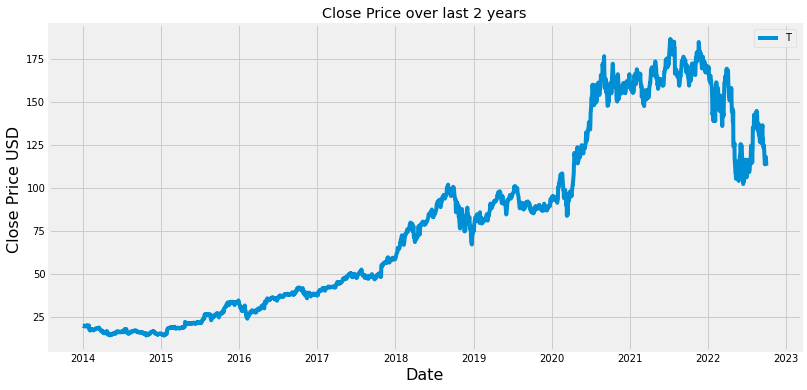

In [6]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.figure(figsize=(12,6))
plt.title("Close Price over last 2 years")
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD ', fontsize=16)
plt.plot()
for ticker in tickers: 
    plt.legend(ticker)
    

In [7]:
data = df.filter(['Close'])
dataset = data.values
training_set_len = math.ceil(len(dataset) * 0.80)

training_set_len


1763

In [8]:
#Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.03223147],
       [0.03178728],
       [0.03097147],
       ...,
       [0.6019086 ],
       [0.58326998],
       [0.5728184 ]])

In [9]:
train_data = scaled_data[0:training_set_len, :]

x_train = [] # independant
y_train = [] # dependant
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])



In [10]:
x_train, y_train = np.array(x_train), np.array(y_train) 

In [11]:
# reshape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1703, 60, 1)

In [12]:
#build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [13]:
#compile
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
#Train
model.fit(x_train, y_train, batch_size=1, epochs=1)

1703/1703 [==============================] - 26s 14ms/step - loss: 0.0012


In [15]:
#Create the testing set
test_data = scaled_data[training_set_len - 60: , :]
#create the data sets x_test, y_test
x_test = []
y_test = dataset[training_set_len: , :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [16]:
x_test = np.array(x_test)


In [17]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [18]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) 


14/14 [==============================] - 1s 10ms/step


In [19]:
rmse =np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

9.445513830922781

C:\Users\xande\AppData\Local\Temp\ipykernel_22624\3630715489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


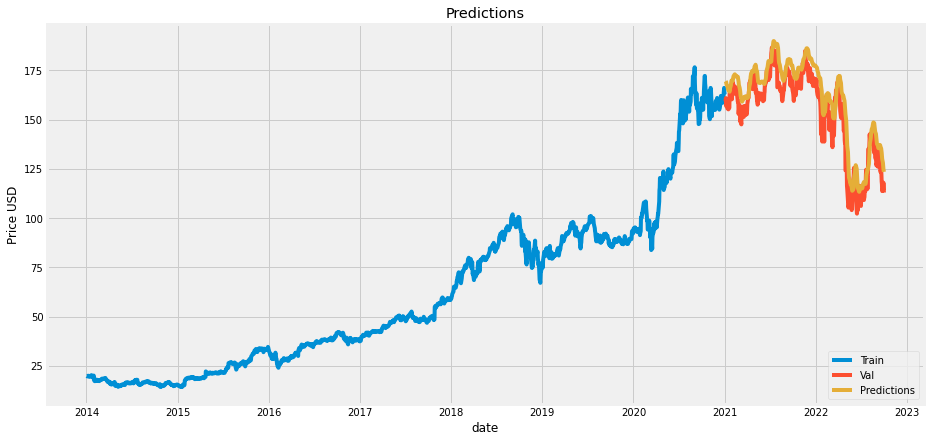

In [24]:
train = data[0:training_set_len] 
valid = data[training_set_len:]
valid['Predictions'] = predictions
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.figure(figsize=(14,7))
plt.title('Predictions')
plt.xlabel('date')
plt.ylabel('Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
# show valid and predicted price 
valid

,Close,Predictions
Date,,
2021-01-04,159.331497,169.517654
2021-01-05,160.925507,169.312637
2021-01-06,156.919006,169.087463
2021-01-07,158.108002,168.343216
2021-01-08,159.134995,167.654709
...,...,...
2022-09-26,115.150002,128.099106
2022-09-27,114.410004,126.423325
2022-09-28,118.010002,124.965530
